In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from tensorboard.plugins.hparams import api as hp

In [2]:
data = pd.read_csv("../solutions/galaxyquasar.csv")
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])

In [4]:
le = LabelEncoder()

#Assign unique integers: 1 QSO, 0 galaxy
data['class'] = le.fit_transform(data['class']) 
label_class = le.inverse_transform(data['class'])
class_name = le.classes_
print('Class names: ', class_name)
print('Labels: ', label_class)

Class names:  ['GALAXY' 'QSO']
Labels:  ['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


In [5]:
scaler = StandardScaler().set_output(transform="pandas")

X = np.array([u_g, g_r, r_i, i_z]).T
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, data['class'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.16, random_state=42)

# Initializing a neural network by Tensorflow

In [6]:
init_num_units = 5
init_dropout = 0.1
init_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
init_activation = 'relu'

In [7]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name = 'recall'),
]

def make_model(metrics=METRICS):
  model = keras.Sequential([
      keras.layers.InputLayer(shape = (X_train.shape[-1],)),
      keras.layers.Dense(
          init_num_units, activation=init_activation),
      keras.layers.Dropout(init_dropout),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=init_optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  print(metrics)
  return model

In [8]:
model = make_model()
model.summary()

[<BinaryCrossentropy name=cross entropy>, <BinaryAccuracy name=accuracy>, <Precision name=precision>, <Recall name=recall>]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7769 - cross entropy: 0.5028 - loss: 0.5028 - precision: 0.4450 - recall: 0.8667 - val_accuracy: 0.9807 - val_cross entropy: 0.1310 - val_loss: 0.1310 - val_precision: 0.9408 - val_recall: 0.9230
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9686 - cross entropy: 0.1263 - loss: 0.1263 - precision: 0.9182 - recall: 0.8515 - val_accuracy: 0.9801 - val_cross entropy: 0.0819 - val_loss: 0.0819 - val_precision: 0.9469 - val_recall: 0.9118
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9778 - cross entropy: 0.0915 - loss: 0.0915 - precision: 0.9424 - recall: 0.9004 - val_accuracy: 0.9807 - val_cross entropy: 0.0768 - val_loss: 0.0768 - val_precision: 0.9478 - val_recall: 0.9153
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9794 - cross entropy: 0.0856 - loss: 0.0856 - precision: 0.9409 - recall: 0.9113 - val_accuracy: 0.9812 - val_cross entropy: 0.0760 - val_lo

In [10]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [12]:
cm = confusion_matrix(y_test, test_pred > 0.5)
test_results = model.evaluate(X_test, y_test, verbose=0)
print('Loss : ' + str(test_results[0]))
print('Accuracy : ' + str(test_results[2]))
print('Precision : ' + str(test_results[3]))
print('Recall : ' + str(test_results[4]))
cm

Loss : 0.07491294294595718
Accuracy : 0.981249988079071
Precision : 0.9471412897109985
Recall : 0.925184428691864


array([[5402,   49],
       [  71,  878]], dtype=int64)

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


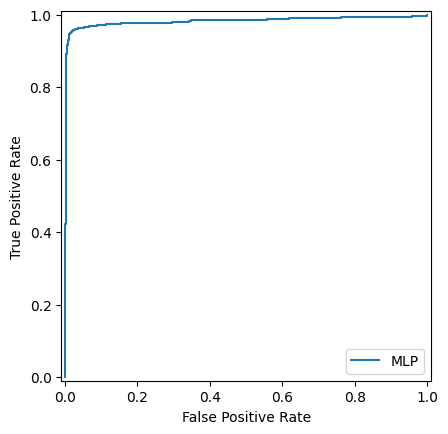

In [13]:
fpr, tpr, threshold = roc_curve(y_test, model.predict(X_test))
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name = 'MLP').plot();

# Tuning the hyperparameters

In [14]:
%load_ext tensorboard

In [15]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([5,10,15,20]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adagrad']))
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))

METRIC_ACCURACY = 'accuracy'

!rm -rvf accuracy/hparam_tuning

with tf.summary.create_file_writer('accuracy/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_ACTIVATION],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='accuracy')]
  )

removed 'accuracy/hparam_tuning/events.out.tfevents.1720617539.LAPTOP-B3RQBVHD.17108.0.v2'
removed 'accuracy/hparam_tuning/run-0/events.out.tfevents.1720617539.LAPTOP-B3RQBVHD.17108.1.v2'
removed directory 'accuracy/hparam_tuning/run-0'
removed 'accuracy/hparam_tuning/run-1/events.out.tfevents.1720617542.LAPTOP-B3RQBVHD.17108.2.v2'
removed directory 'accuracy/hparam_tuning/run-1'
removed 'accuracy/hparam_tuning/run-10/events.out.tfevents.1720617573.LAPTOP-B3RQBVHD.17108.11.v2'
removed directory 'accuracy/hparam_tuning/run-10'
removed 'accuracy/hparam_tuning/run-11/events.out.tfevents.1720617576.LAPTOP-B3RQBVHD.17108.12.v2'
removed directory 'accuracy/hparam_tuning/run-11'
removed 'accuracy/hparam_tuning/run-12/events.out.tfevents.1720617579.LAPTOP-B3RQBVHD.17108.13.v2'
removed directory 'accuracy/hparam_tuning/run-12'
removed 'accuracy/hparam_tuning/run-13/events.out.tfevents.1720617582.LAPTOP-B3RQBVHD.17108.14.v2'
removed directory 'accuracy/hparam_tuning/run-13'
removed 'accuracy/hpa

In [16]:
def validate_model(hparams):
  model = keras.Sequential([
      keras.layers.InputLayer(shape = (X_train.shape[-1],)),
      keras.layers.Dense(
          hparams[HP_NUM_UNITS], activation = hparams[HP_ACTIVATION],),
      keras.layers.Dropout(hparams[HP_DROPOUT]),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(name = 'accuracy', threshold = 0.5)])
  model.fit(X_train, y_train, epochs=1)
  _, accuracy = model.evaluate(X_val, y_val)
  return (accuracy)

In [17]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = validate_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [18]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.values):
    for optimizer in HP_OPTIMIZER.domain.values:
      for activation in HP_ACTIVATION.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_ACTIVATION: activation,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('accuracy/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'adagrad', 'activation': 'relu'}
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8000 - loss: 0.6992
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8583 - loss: 0.6183
--- Starting trial: run-1
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'adagrad', 'activation': 'sigmoid'}
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1489 - loss: 1.1011
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1380 - loss: 1.0000
--- Starting trial: run-2
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'adam', 'activation': 'relu'}
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8314 - loss: 0.5040
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9788 - loss: 0.1576
--- Starting trial: run-3
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'adam', 'activation': 'sigmoid'}
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8557 - loss: 0.4485
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accu

In [19]:
%tensorboard --logdir accuracy/hparam_tuning --host localhost --port 8358

These are the best values for the hyperparameters:

In [24]:
tuned_num_units = 10
tuned_dropout = 0.5
tuned_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
tuned_activation = 'relu'

# Initializing our best model

In [25]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name = 'recall'),
]

def make_model(metrics=METRICS):
  model = keras.Sequential([
      keras.layers.InputLayer(shape = (X_train.shape[-1],)),
      keras.layers.Dense(
          tuned_num_units, activation=tuned_activation),
      keras.layers.Dropout(tuned_dropout),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=tuned_optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  print(metrics)
  return model

In [26]:
model = make_model()
model.summary()

[<BinaryCrossentropy name=cross entropy>, <BinaryAccuracy name=accuracy>, <Precision name=precision>, <Recall name=recall>]


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8786 - cross entropy: 0.3894 - loss: 0.3894 - precision: 0.6308 - recall: 0.4220 - val_accuracy: 0.9774 - val_cross entropy: 0.1251 - val_loss: 0.1251 - val_precision: 0.9688 - val_recall: 0.8697
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9420 - cross entropy: 0.1624 - loss: 0.1624 - precision: 0.9255 - recall: 0.6479 - val_accuracy: 0.9803 - val_cross entropy: 0.0938 - val_loss: 0.0938 - val_precision: 0.9583 - val_recall: 0.9013
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9514 - cross entropy: 0.1264 - loss: 0.1264 - precision: 0.9408 - recall: 0.6966 - val_accuracy: 0.9805 - val_cross entropy: 0.0868 - val_loss: 0.0868 - val_precision: 0.9557 - val_recall: 0.9055
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9478 - cross entropy: 0.1337 - loss: 0.1337 - precision: 0.9271 - recall: 0.6832 - val_accuracy: 0.9806 - val_cross entropy: 0.0846 - val_lo

In [28]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Results

In [29]:
cm = confusion_matrix(y_test, test_pred > 0.5)
test_results = model.evaluate(X_test, y_test, verbose=0)
print('Loss : ' + str(test_results[0]))
print('Accuracy : ' + str(test_results[2]))
print('Precision : ' + str(test_results[3]))
print('Recall : ' + str(test_results[4]))
cm

Loss : 0.08328191936016083
Accuracy : 0.9807812571525574
Precision : 0.9412392973899841
Recall : 0.9283456206321716


array([[5396,   55],
       [  68,  881]], dtype=int64)

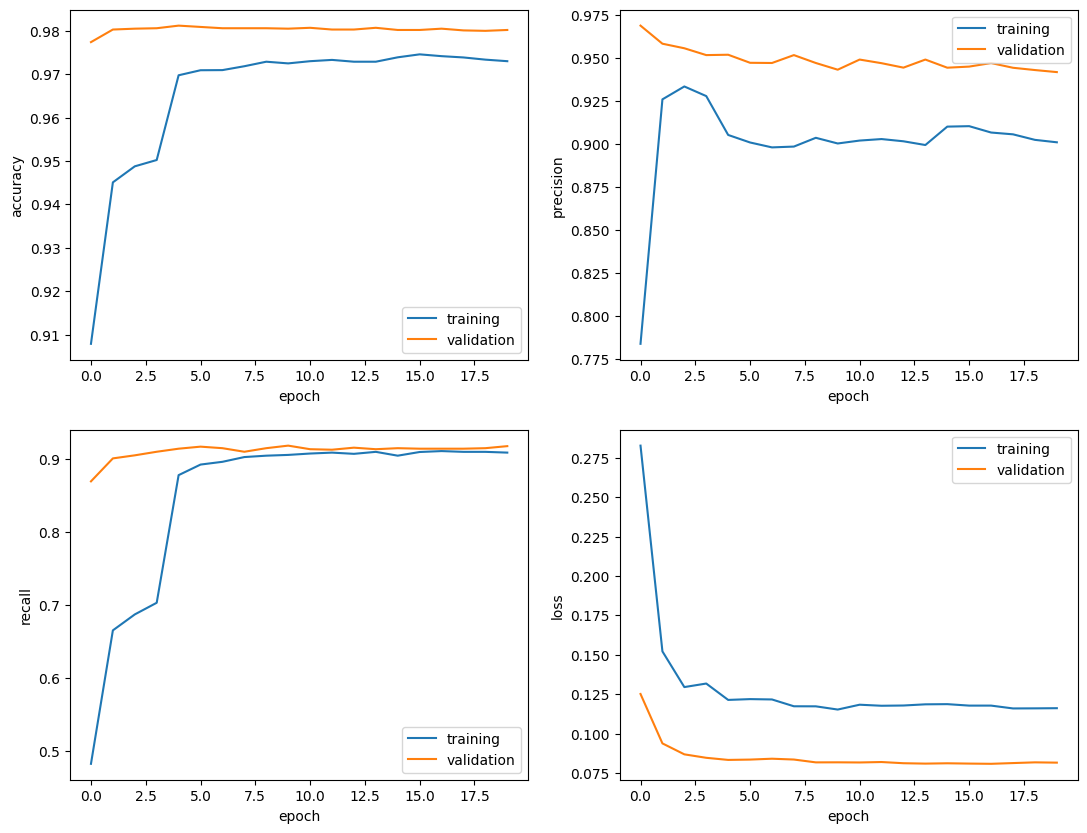

In [30]:
fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(221)
ax.plot(history.history['accuracy'], label = 'training')
ax.plot(history.history['val_accuracy'], label = 'validation')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

ax1 = fig.add_subplot(222)
ax1.plot(history.history['precision'], label = 'training')
ax1.plot(history.history['val_precision'], label = 'validation')
ax1.set_ylabel('precision')
ax1.set_xlabel('epoch')
ax1.legend()

ax3 = fig.add_subplot(223)
ax3.plot(history.history['recall'], label = 'training')
ax3.plot(history.history['val_recall'], label = 'validation')
ax3.set_ylabel('recall')
ax3.set_xlabel('epoch')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.plot(history.history['loss'], label = 'training')
ax4.plot(history.history['val_loss'], label = 'validation')
ax4.set_ylabel('loss')
ax4.set_xlabel('epoch')
ax4.legend()

plt.show()

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


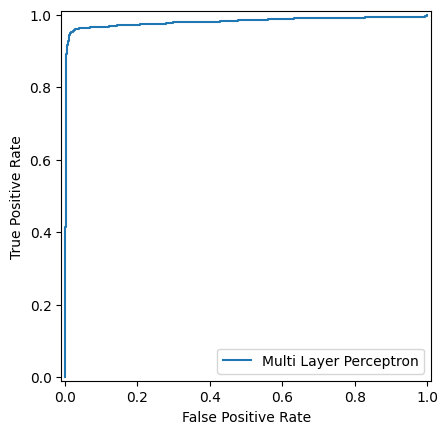

In [31]:
fpr, tpr, threshold = roc_curve(y_test, model.predict(X_test))
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name = 'Multi Layer Perceptron').plot();

The only hyperparameter that has changed after the cross validation is the number of neurons used in the hidden layer. The resulting accuracy is slightly better.

Looking at the performance obtained by simpler classiefiers we can adfirm that using Deep Learning on this problem is too much expensive and we obtain a similar result.